### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')

In [2]:
from sklearn.datasets import fetch_olivetti_faces

import time
import timeit
%matplotlib inline

import scipy
import scipy.stats
import matplotlib.pyplot as plt

from ipywidgets import interact

plt.style.use('fivethirtyeight')
%matplotlib inline

from numpy.testing import assert_allclose

**Compute the sample mean vector of a matrix**

$\overline{X}$ = $\displaystyle\frac{1}{N}$ (${X}^T$ ${j}$), where 
- ${j}$ $\in$ $\mathbb{R}^{n \times 1}$
- $\overline{X}$: Sample mean vector
- ${X}^T$: Transpose of the input matrix of shape (N, D)
- ${N}$: Size of the dataset
- ${D}$: Dimensionality of the dataset

In [3]:
def mean_x(X):
    N, D = X.shape
    j = np.ones(N)
    XTJ = X.T @ j
    mean_vector = XTJ / N

    return mean_vector

**Compute the covariance matrix of a dataset**

${S}$ = $\displaystyle\frac{1}{N}$ ${X}^T$ (${I}$ - $\displaystyle\frac{1}{N}$ ${J}$) ${X}$, where
- ${X}$: Input matrix of shape (N, D)
- ${N}$: Size of the dataset
- ${D}$: Dimensionality of the dataset
- ${X}^T$: Transpose of the input matrix
- ${I}$ $\in$ $\mathbb{R}^{n \times n}$: Identitiy matrix
- ${J}$ $\in$ $\mathbb{R}^{n \times n}$: Unit matrix

In [4]:
def cov(X):
    N, D = X.shape
    I = np.identity(N)
    J = np.ones((N,N))
    S = (1/N) * X.T @ (I - (1/N) * J) @ X

    return S

**Data normalization**

$\bar{X}$ = $\frac{X - μ}{σ}$, where
- $\bar{X}$: Normalized dataset with mean zero and unit variance

In [5]:
def normalize(X):
    μ = mean_x(X)
    X_bar = X - μ

    return X_bar, μ

**Compute eigenvalues and eigenvectors**

Where
- ${S}$: Covariance matrix
- ${\lambda}$: Eigenvalues sorted in descending order of the eigen values
- ${V}$: Eigenvectors sorted in descending order of the eigen values

In [6]:
def eig(S):
    λ, V = np.linalg.eig(S)
    sort_indices = np.argsort(λ)[::-1]

    return λ[sort_indices], V[:, sort_indices]

**Compute Projection Matrix onto the space spanned by `B`**

${P}$ = ${B}$ (${B}^T$ ${B})^{-1}$ ${B}^T$, where
- ${B}$: Basis of the subspace with dimension (D, M)

In [7]:
def projection_matrix(B):
    P = B @ np.linalg.inv(B.T @ B) @ B.T

    return P

**Principal Component Analysis**


The function below takes advantage of the functions implemented above to perform PCA.

In [8]:
def PCA(X, num_components):
    # Normalization of the dataset so that they have zero mean
    X_normalized, μ = normalize(X)

    # Compute covariance matrix S
    S = cov(X)

    # Compute the eigenvalues (λ) and eigenvectors (V) of S in descending order of the eigenvalues
    λ, V = eig(S)

    # Take the top "num_components" of λ and V
    principal_values = λ[:num_components]
    principal_components = V[:, :num_components]

    # Compute the projection matrix onto the space spanned by the principal components
    P = projection_matrix(principal_components)

    # Reconstruct data using the basis spanned by the principal components
    X_reconsted = (P @ X_normalized.T).T + μ

    return X_reconsted, μ, principal_values, principal_components

Generate a dataset X from a 2D Gaussian distribution

In [9]:
def draw_vector(v0, v1, ax=None, label=None):
    """Draw a vector from v0 to v1."""
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, 
                    color='k')
    ax.annotate('', v1, v0, arrowprops=arrowprops, label=label)

In [10]:
D = 2
N = 10

mvn = scipy.stats.multivariate_normal(
    mean=np.ones(D, dtype=np.float64), 
    cov=np.array([[1, 0.8], [0.8, 1]], dtype=np.float64)
)

X = mvn.rvs((100,), random_state=np.random.RandomState(0))

**Compare the results of our PCA implementation with the implementation of scikit-learn**

In [11]:
from sklearn.decomposition import PCA as SKPCA

In [12]:
for num_component in range(1, 3):
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver="full")
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(X))
    reconst, _, _, _ = PCA(X, num_component)
    # The difference in the result should be very small (<10^-20)
    print(
        "difference in reconstruction for num_components = {}: {}".format(
            num_component, np.square(reconst - sklearn_reconst).sum()
        )
    )

difference in reconstruction for num_components = 1: 3.404427844094429e-29
difference in reconstruction for num_components = 2: 1.1327549560907966e-29


**As we can see above, our almost achieves identical results as the scikit-learn implementation.**

**We can also visualize PCA:**

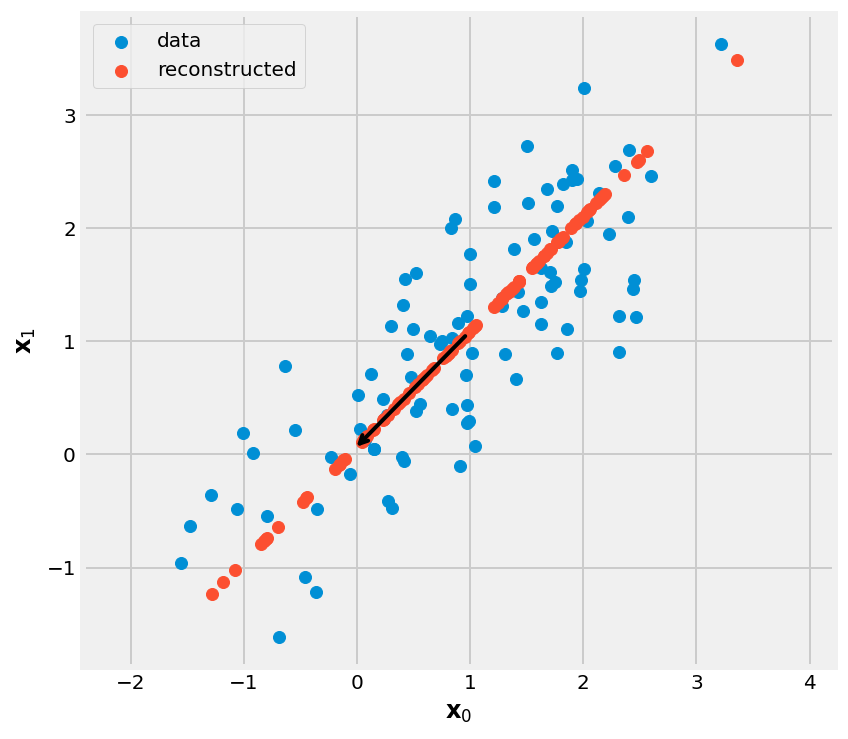

In [13]:
num_components = 1
X_reconst, mean, principal_values, principal_components = PCA(X, num_components)

fig, ax = plt.subplots(figsize=(6, 6))
# eig_vals, eig_vecs = eig_vals[:num_components], eig_vecs[:, :num_components]
ax.scatter(X[:, 0], X[:, 1], label='data')
for (princial_variance, principal_component) in (zip(principal_values, principal_components.T)):
    draw_vector(
        mean, mean + np.sqrt(princial_variance) * principal_component, 
        ax=ax)
ax.scatter(X_reconst[:, 0], X_reconst[:, 1], label='reconstructed')
plt.axis('equal');
plt.legend();
ax.set(xlabel='$\mathbf{x}_0$', ylabel='$\mathbf{x}_1$');

**Principal Component Analysis for high-dimensional datasets**

In [14]:
def PCA_high_dim(X, num_components):
    N, D = X.shape

    # Normalization of the dataset so that they have zero mean
    X_normalized, μ = normalize(X)

    # Find the covariance matrix
    M = np.dot(X_normalized, X_normalized.T) / N

    # Compute the eigenvalues (λ) and eigenvectors (V) of S in descending order of the eigenvalues
    λ, V = eig(M)

    # Compute eigenvectors for the original covariance matrix
    XV = X_normalized.T @ V

    # Choose eingenvectors with the `num_components` largest eigenvalues to be the basis of principal subspace U
    U = XV[:, :num_components]

    # Compute the orthogonal projection of the data onto the subspace spanned by columns of U
    P = projection_matrix(U[:, :num_components])

    # Reconstruct the data
    X_reconstructed = (P @ X_normalized.T).T + μ

    return X_reconstructed, μ, λ, V

Next, we will compare the implementation from the PCA in higher dimensions with the model from scikit-learn.

In [15]:
for num_component in range(1, 3):
    pca = SKPCA(n_components=num_component, svd_solver="full")
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(X))
    reconst, _, _, _ = PCA_high_dim(X, num_component)
    print(
        "difference in reconstruction for num_components = {}: {}".format(
            num_component, np.square(reconst - sklearn_reconst).sum()
        )
    )

difference in reconstruction for num_components = 1: (3.5091984330690947e-29+0j)
difference in reconstruction for num_components = 2: (1.3971466188562764e-29+0j)
